<a href="https://colab.research.google.com/github/MelikbekyanAshot/Data-Science/blob/main/Habr%20Parser/HabrParser.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Импорт библиотек

In [ ]:
!pip install loguru

     |████████████████████████████████| 57 kB 4.1 MB/s 


In [ ]:
!pip install requests[security]

     |████████████████████████████████| 55 kB 3.0 MB/s 
     |████████████████████████████████| 3.6 MB 16.6 MB/s 


In [ ]:
!pip install pymorphy2

     |████████████████████████████████| 55 kB 3.2 MB/s 
     |████████████████████████████████| 8.2 MB 12.0 MB/s 


In [ ]:
import requests
from requests.adapters import HTTPAdapter
from requests.packages.urllib3.util.retry import Retry
from bs4 import BeautifulSoup

from concurrent.futures import ThreadPoolExecutor

from loguru import logger

import pandas as pd
import numpy as np

from datetime import datetime
from datetime import date
from dateutil.relativedelta import relativedelta

import re

from collections import Counter

import string
import nltk
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk import sent_tokenize, word_tokenize, regexp_tokenize
from pymorphy2 import MorphAnalyzer

from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Загрузчик

In [ ]:
class Loader:  
  """Загрузчик страниц статей по разделам сайта https://habr.com.
  
  Args:
    loaded_articles (dict): словарь загруженных статей, ключ - id статьи,
                            значение - словарь из 3 значений (раздел, статья,
                            комментарии к статье)
    date_of_loading (datetime): дата загрузки данных.
  """
  def __init__(self, loaded_articles=dict()):
    """ Инициирует свойства класса."""
    self.date_of_loading = datetime.now()
    self.loaded_articles = loaded_articles

  def start_loading(self):
    """Инициирует загрузку веб-страниц."""    
    sections = ['develop', 'admin', 'design', 'management', 'marketing', 'popsci']
    with ThreadPoolExecutor(6) as executor:
      executor.map(self.__load_pages, sections)

  def __load_pages(self, section:str):
    """Загружает код веб-страницы со статьей и комментариями.
    
    Args:
      section (str): название раздела, из которого нужно загрузить информацию.
    """
    for page in range(1, 51):
      habr_url = 'https://habr.com'
      page_url = f'https://habr.com/ru/flows/{section}/top25/page{page}'
      soup = self.__get_soup(page_url) 
      
      for article in soup.find_all('article'):
        article_date = article.find('time').text
        if self.__check_date(article_date):
          try:
            article_id = article.get('id')
            if article_id not in self.loaded_articles:
              if article.find('div').find('h2').find('a'):
                article_url = habr_url + article.find('div').find('h2').find('a').get('href')
                article_soup = self.__get_soup(article_url)
                body = article_soup.find('div', {'class', 'tm-article-presenter__body'})
              else:
                article_url = f'{habr_url}/ru/article/{article_id}/'
                article_soup = self.__get_soup(article_url)
                body = article_soup.body

              comments_url = article_url + 'comments/'
              comments_soup = self.__get_soup(comments_url)
              comments = comments_soup.find('div', {'class', 'tm-comments-wrapper__wrapper'})
              
              self.loaded_articles[article_id] = {'section': section, 'article': body, 'comments': comments}
              logger.success(f'Загружена статья {article_url}')
            else:
              first_section = self.loaded_articles[article_id]['section']
              self.loaded_articles[article_id]['section'] = first_section + ' ' + section
          except Exception as e:
            logger.error(f'Статья не загружена: id {article_id}, url {article_url}, date {article_date}\nException: {e}')
        else:
          break

  def __get_soup(self, url: str) -> BeautifulSoup:
    """Делает запрос веб-странице.
    Args:
      url (str): ссылка на веб-страницу.

    Returns:
      soup (bs4.BeautifulSoup): код веб-страницы.
    """
    headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; U; PPC Mac OS X 10_5_7 rv:5.0; sl-SI) AppleWebKit/533.22.1 (KHTML, like Gecko) Version/5.0 Safari/533.22.1',
               'Connection': 'keep-alive',
               'accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9',
               'upgrade-insecure-requests': '1',
               'Referer': 'https://cssspritegenerator.com',
               'Accept-Charset': 'ISO-8859-1,utf-8;q=0.7,*;q=0.3',
               'Accept-Encoding': 'none',
               'Accept-Language': 'en-US,en;q=0.8'}
    response = requests.Session()
    retry = Retry(connect=3, backoff_factor=0.5)
    adapter = HTTPAdapter(max_retries=retry)
    response.mount('http://', adapter)
    response.mount('https://', adapter)
    page = requests.get(url, headers=headers)
    soup = BeautifulSoup(page.text, 'lxml')
    return soup

  def __get_last_date(self) -> str:
    """Вычисляет дату, которая была 3 месяца назад.

    Returns:
      last_date (str): дата, которая была 3 месяца назад.
    """
    current = datetime.now()         
    delta = relativedelta(months=-3)
    last_date = current + delta 
    last_date = f'{last_date.year}-{last_date.month}-{last_date.day}'
    return last_date
  
  def __check_date(self, article_date) -> bool:
    """Проверяет, что с момента указанной даты прошло менее 3 месяцев.

    Args:
      article_date (str): дата публикации статьи.

    Returns:
      True - если статье меньше 3 месяцев, False - в ином случае.
    """
    if 'сегодня' in article_date or 'вчера' in article_date:
      return True
    last_date = datetime.fromisoformat(self.__get_last_date())
    article_date = datetime.fromisoformat(Utilities.convert_date(article_date))
    current_date = datetime.now()
    if last_date <= article_date <= current_date:
      return True
    return False

  

# Парсер

In [ ]:
class Parser:
  """Парсер полезной информации из загруженных статей.

  Args:
    date_of_loading (datetime): дата загрузки данных.
    data (dict): загруженная информация про статьи.
    df (pd.DataFrame): полезная информаиця, собранная в датафрейм.
  """
  def __init__(self, date_of_loading):
    """Инициирует свойства парсера."""
    self.date_of_loading = date_of_loading
    self.data = dict()
    self.df = pd.DataFrame()

  def parse_articles(self, data):
    """Парсинг полезной информации из загруженных данных.

    Args:
      data (dict): загруженные данные.
    """
    sections, titles, hubs, tags, positive_votes, negative_votes, views, bookmarks, comments_number, authors, commentators, comments_text, days_past =  \
    [], [], [], [], [], [], [], [], [], [], [], [], []
    for article in data:
      section = data[article]['section']
      body = data[article]['article']
      comments = data[article]['comments']

      try:
        titles.append(body.find('h1').find('span').text)
        
        date_ = body.find('span', {'class': 'tm-article-snippet__datetime-published'})
        days_past.append(date_.text if date_.text != None else None)

        hubs.append(' '.join([tag.text for tag in body.find_all('span', {'class': 'tm-article-snippet__hubs-item'})]))

        tags.append(' '.join([tag.text for tag in body.find_all('a', {'class': 'tm-tags-list__link'})]))

        pos_votes_ = body.find('div', {'class': "tm-votes-meter tm-article-rating__votes-switcher"})
        positive_votes.append(pos_votes_.find('svg').text.split()[-3][1:] if pos_votes_.find('svg').text.split()[-3][1:] != None else None)

        neg_votes_ = body.find('div', {'class': "tm-votes-meter tm-article-rating__votes-switcher"})
        negative_votes.append(neg_votes_.find('svg').text.split()[-1][1:] if neg_votes_.find('svg').text.split()[-1][1:] != None else None)

        views_ = body.find('div', {'class': 'tm-article-sticky-panel'}).find('span', {'class': 'tm-icon-counter__value'})
        views.append(views_.text if views_.text != None else None)

        bookmarks_ = body.find('span', {'class': 'bookmarks-button__counter'}).text
        bookmarks.append(re.search(r'\d+', bookmarks_).group())

        comments_number_ = comments.find('span', {'class': 'tm-comments-wrapper__comments-count'})
        comments_number.append(re.search(r'\d+', comments_number_.text).group() if comments_number_ != None else 0) 

        commentators_ = [commentator.get('title') for commentator in comments.find_all('a', {'class': 'tm-user-info__userpic'})]
        commentators.append(' '.join(commentators_))
        
        author_ = body.find('span', {'class': 'tm-user-info tm-article-snippet__author'})
        if author_ != None:
          authors.append(re.sub('[!\n]', '', author_.text))
        else:
          company_blog_ = body.find('a', {'class': 'tm-article-snippet__hubs-item-link tm-article-snippet__hubs-item-link_megapost'}).find('span')
          authors.append(company_blog_.text[:company_blog_.text.find(',')])

        comments_text_ = ' '.join([commentary.text for commentary in comments.find_all('div', {'class': re.compile(r'tm-comment__body-content.*')})])
        comments_text.append(comments_text_ if comments_text_ != None else None)

        sections.append(section)
      except Exception as e:
        logger.error(f'Ошибка при парсинге статьи {article}:\n{e}')

    self.data =  {'sections': sections, 'titles': titles, 'hubs': hubs, 
            'tags': tags, 'positive_votes': positive_votes, 
            'negative_votes': negative_votes, 'views': views, 
            'bookmarks': bookmarks, 'comments_number': comments_number, 
            'authors': authors, 'commentators': commentators, 'comments': comments_text, 'days_past': days_past}

  def preprocess_df(self):
    """Предобработка датафрейма: преобразование типов данных, удаление пустых 
    строк и пробелов до и после имени автора, вычисления."""
    self.df['views'] = self.df['views'].fillna(self.df['views'].dropna().mode())
    self.df['views'] = list(map(self.__convert_views, self.df['views']))
    self.df['positive_votes'] = pd.to_numeric(self.df['positive_votes'])
    self.df['negative_votes'] = pd.to_numeric(self.df['negative_votes'])
    self.df['bookmarks'] = pd.to_numeric(self.df['bookmarks'])
    self.df['comments_number'] = pd.to_numeric(self.df['comments_number'])
    self.df['authors'] = list(map(str.strip, self.df['authors']))
    self.df['days_past'] = list(map(self.__count_past_days, self.df['days_past']))
    self.df['days_past'] = pd.to_numeric(self.df['days_past'])

  def __convert_views(self, views_number: str) -> int:
    """Конвертирует количество просмотров/

    Args:
      views_number: str количество просмотров.

    Returns:
      views_number: int количество просмотров.

    Example:
      >>> views_number('2.5K')
      >>> 2500
    """
    if 'M' in views_number:
      return int(1e6* float(views_number[:views_number.find('M')]))
    if 'K' in views_number:
      return int(1e3* float(views_number[:views_number.find('K')]))

  def make_df(self, data: dict):
    """Создает датафрейм и присваивает его свойству парсера."""
    self.df = pd.DataFrame(data=data)

  def __count_past_days(self, date: str) -> int:
    """Считает количество дней, прошедших с момента загрузки данных.

    Args:
      date (str): дата отсчета

    Returns:
      Количество дней между датами.
    """
    if 'сегодня' in date:
      return 0
    if 'вчера' in date:
      return 1
    date = Utilities.convert_date(date)
    return (self.date_of_loading - datetime(*[int(_) for _ in date.split('-')])).days


# Аналитика

In [ ]:
class Analytics:
  """Аналитика данных."""
  @staticmethod
  def get_top_users(users, limit=30) -> list:
    """Вычисляет самых активных пользователей. Активность определяется по количеству публикаций.
    
    Args:
      users: пользователи.
      limit (int): верхнее ограничение на количество авторов в результирующем списке.
    
    Returns:
      Отсортированный список самых активных пользователей.
    """
    users_activity = Counter(users)
    return sorted(users_activity.items(), key=lambda x: x[1], reverse=True)[:limit]

  @staticmethod
  def plot_wordcloud(text: str, title: str):
    """Строит облако слов по переданному тексту.
    
    Args:
      text (str): текст, по которому строится облако слов.
      title (str): название графика."""
    wordcloud = WordCloud(min_font_size=18, max_font_size=150,   
                          width=1600, height=900, max_words=150, 
                          background_color="white", collocations=False,
                          stopwords=stopwords.words("russian")).generate(text)
    plt.figure(figsize=(8, 8), facecolor=None)
    plt.imshow(wordcloud)
    plt.title(title)
    plt.axis("off")
    plt.tight_layout(pad=5)
    plt.show()

  @staticmethod
  def plot_freq_dist(text, n=30):
    """Строит частотный график слов из переданного текста."""
    fdist = FreqDist(text, )
    fdist.plot(n,cumulative=False) 

  @staticmethod
  def preprocess_text(text):
    """Предобрабатывает текст, переводит в нижний регистр, убирает знаки 
    пунктуации, специальные символы, стопслова, проводит токенизацию.
    
    Args:
      text

    Returns:"""
    text = text.lower()
    spec_chars = string.punctuation + string.digits + '\n\xa0«»\t—-#@№…'
    text = Analytics.__remove_chars_from_text(text, spec_chars)
    text_tokens = word_tokenize(text)
    text = nltk.Text(text_tokens)
    russian_stopwords = stopwords.words("russian")
    text = Analytics.__remove_stopwords(text, russian_stopwords)
    return ' '.join(text)

  def __remove_stopwords(text: str, stopwords: str) -> list:
    return [word for word in text if not word in stopwords]

  def __remove_chars_from_text(text, chars) -> str:
    return ''.join([ch for ch in text if ch not in chars])

  @staticmethod
  def calc_engagement_rate(df: pd.DataFrame):
    """Вычисляет рейтинг вовлеченности.

    Args:
      df (pd.DataFrame): датафрейм с данными.
    
    Return:
      er_df (pd.DataFrame): датафрейм с данными и рейтингом вовлеченности.
    """
    er = (df.positive_votes + df.negative_votes + 2 * df.bookmarks + df.comments_number) \
          / (df.views) * 100
    er_df = df
    er_df['ER'] = er
    return er_df

  @staticmethod
  def lemmatization(text: str) -> str:
    """Лемматизация слов"""
    text =  [sent for sent in sent_tokenize(text)]
    text = ' '.join(list(map(lambda x: ' '.join(Analytics.__tokenize_n_normalize(x)), text)))
    return text

  @staticmethod
  def __tokenize_n_normalize(sent, pat=r"(?u)\b\w\w+\b", morph=MorphAnalyzer()):
    """Токенизация и нормализация слов."""
    return [morph.parse(tok)[0].normal_form 
            for tok in regexp_tokenize(sent, pat)]


# Вспомогательный класс

In [ ]:
class Utilities:
  """Вспомогательный класс."""
  @staticmethod
  def set_logging_settings(path: str, name: str):
    """Настройка логгирования.
    
    Args:
      path (str): путь файла логгирования.
      name (str): название файла логгирования.
    """
    logger.remove()
    logger.add(path + name,
               format='{time:YYYY-MM-DD HH:mm:ss.SSS} | {level} | {message}',
               backtrace=True, diagnose=True, enqueue=True)

  @staticmethod
  def convert_date(date: str):
    """Конвертирует дату в общий формат.

    Args:
      date (str): - дата.

    Returns:
      Дата в общем формате.

    Example:
      >>> convert_date('15 ноября 2021 в 13:05')
      >>> 2021-11-15
    """
    rep = {'января': '1', 'февраля': '2', 'марта': '3', 'апреля': '4',
          'мая': '5', 'июня': '6', 'июля': '7', 'августа': '8',
          'сентября': '9', 'октября': '10', 'ноября': '11', 'декабря': '12'}
    rep = dict((re.escape(k), v) for k, v in rep.items()) 
    pattern = re.compile("|".join(rep.keys()))
    date = pattern.sub(lambda m: rep[re.escape(m.group(0))], date)
    date = date.split()
    year = str(datetime.now().year) if not re.findall(r'\d{4}', ''.join(date)) else str(date[2]) 
    month = date[1]
    day = date[0]
    dt_object = datetime.strptime(f'{year}-{month}-{day}', '%Y-%m-%d')
    return datetime.strftime(dt_object, '%Y-%m-%d')


# Загрузка данных и парсинг

Для корректной работы необходимо указать свой путь

In [ ]:
Utilities.set_logging_settings('/content/drive/MyDrive/МИРЭА/AI/Стажировка/Анализ данных/', 'loading.log')

Загрузка данных

In [ ]:
loader = Loader()
loader.start_loading()

Загрузка данных при скорости входящего интернет соединения ~30 МБит/с длится около 20 минут. Время загрузки данных можно уменьшить, увеличив скорость входящего интернет соединения.

Парсинг данных

In [ ]:
Utilities.set_logging_settings('/content/drive/MyDrive/МИРЭА/AI/Стажировка/Анализ данных/', 'parsing.log')

In [ ]:
parser = Parser(loader.date_of_loading)
parser.parse_articles(loader.loaded_articles)

Обработка и сохранение в файл

In [ ]:
parser.make_df(parser.data)
parser.preprocess_df()
parser.df.to_csv('/content/drive/MyDrive/МИРЭА/AI/Стажировка/Анализ данных/df.csv')

Чтение датафрейма

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/МИРЭА/AI/Стажировка/Анализ данных/df.csv', index_col=0)

Обзор датафрейма

In [ ]:
df.head()

,sections,titles,hubs,tags,positive_votes,negative_votes,views,bookmarks,comments_number,authors,commentators,comments,days_past
0,develop,Препарируем дельфина: что внутри у Flipper Zero,Производство и разработка электроники * Гаджет...,flipper zero flipper,113,1,11000.0,60,19,vvzvlad,G1K vvzvlad QtRoS arkamax vvzvlad daggert Wild...,Феноменально! Спасибо за качественные фото)Жал...,1
1,design popsci,Гора пластика. Итог: рожки и клюв,Блог компании RUVDS.com Работа с 3D-графикой ...,3d-печать 3d-моделирование 3d-сканер 3d-принте...,62,3,4300.0,18,3,phanerozoi_evidence,SciTeam phanerozoi_evidence FinGeoMa,Очень здорово! Планируется ли создание других ...,2
2,admin develop management popsci,Операционная система Phantom от российского ра...,Блог компании Selectel IT-инфраструктура * Ра...,операционные системы фантом ОС софт,69,9,27000.0,41,90,Ccelebro,sborisov Kotofay QtRoS Kotofay QtRoS Kotofay k...,Приложения работают в общем адресном пространс...,2
3,marketing develop,"Питон против Безумного Макса, или как я посты ...",Информационная безопасность * Разработка веб-с...,хабр провал уязвимость,320,10,16000.0,58,140,kesn,Gedeonych gecube Gedeonych Areso nochkin Popad...,Я прекрасно понимаю какую реакцию вызовет мой ...,2
4,management popsci,"Оффер в Вооруженные Силы РФ, от которого нельз...",Здоровье Лайфхаки для гиков Читальный зал,армия,143,21,34000.0,83,146,VokaMut,navferty eugene08 VokaMut alexeibs sergey-kuzn...,Вместо того чтобы химичить с тэгами внутри xml...,1


Информация

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1170 entries, 0 to 1169
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   sections         1170 non-null   object 
 1   titles           1170 non-null   object 
 2   hubs             1170 non-null   object 
 3   tags             1170 non-null   object 
 4   positive_votes   1170 non-null   int64  
 5   negative_votes   1170 non-null   int64  
 6   views            1168 non-null   float64
 7   bookmarks        1170 non-null   int64  
 8   comments_number  1170 non-null   int64  
 9   authors          1170 non-null   object 
 10  commentators     1149 non-null   object 
 11  comments         1149 non-null   object 
 12  days_past        1170 non-null   int64  
dtypes: float64(1), int64(5), object(7)
memory usage: 128.0+ KB


In [ ]:
df.groupby('sections')['titles'].count()

sections
admin                                16
admin develop                        59
admin develop management              2
admin develop management popsci       2
admin develop popsci                 16
admin management                      7
admin management develop             11
admin management develop popsci       2
admin management popsci              12
admin popsci                         29
admin popsci develop                  5
admin popsci management               1
design                                7
design admin develop                  1
design admin popsci                   2
design develop                        7
design develop popsci                 8
design develop popsci management      1
design management                     1
design management develop             2
design management popsci              1
design management popsci develop      1
design popsci                        16
design popsci develop                 5
develop                        

In [ ]:
df.groupby('sections').describe()['views']

,count,mean,std,min,25%,50%,75%,max
sections,,,,,,,,
admin,16.0,16431.250000,14667.865955,2100.0,5975.0,13000.0,19500.0,51000.0
admin develop,59.0,16006.779661,19053.598306,3300.0,6650.0,9000.0,14500.0,98000.0
admin develop management,2.0,28500.000000,21920.310217,13000.0,20750.0,28500.0,36250.0,44000.0
admin develop management popsci,2.0,20000.000000,9899.494937,13000.0,16500.0,20000.0,23500.0,27000.0
admin develop popsci,16.0,23312.500000,25957.680302,6700.0,10000.0,15000.0,19000.0,106000.0
admin management,7.0,18885.714286,11892.774917,4600.0,10300.0,17000.0,27500.0,35000.0
admin management develop,11.0,21309.090909,21623.896714,1300.0,7150.0,11000.0,25500.0,69000.0
admin management develop popsci,2.0,27500.000000,13435.028843,18000.0,22750.0,27500.0,32250.0,37000.0
admin management popsci,12.0,14308.333333,8810.474998,4400.0,8375.0,12000.0,17500.0,32000.0


# Топ 30 авторов

In [ ]:
for section in ['develop', 'admin', 'design', 'management', 'marketing', 'popsci']:
  authots_activity = Analytics.get_top_users(df[df.sections == section].authors.values)
  print(f'Топ-30 авторов в разделе {section}:')
  for author, activity in authots_activity:
    print(author, activity)
  print('\n')

Топ-30 авторов в разделе develop:
ru_vds 9
pronskiy 7
alexzfort 6
Bright_Translate 6
PatientZero 5
mr-pickles 4
zhovner 3
quasilyte 3
Andrey2008 3
tagir_valeev 3
mvideo 2
MagisterLudi 2
phillennium 2
ynoxinul 2
jar_ohty 2
faiwer 2
vvzvlad 1
Igor_Le 1
feynmanMann 1
shcher 1
shandy 1
epodivilov 1
jobgemws 1
Vvka 1
k_tultseva 1
omotezata 1
WEStor 1
dm_frox 1
engine9 1
catstail1954 1


Топ-30 авторов в разделе admin:
olegtsss 3
ru_vds 2
MrMaxG 1
andreyzaytsev 1
sorcodiv 1
Блог компании Huawe 1
lea 1
1shaman 1
Darksa 1
sudoroot 1
Makson_Herson 1
mvideo 1
Oxyd 1


Топ-30 авторов в разделе design:
Stedihabr 1
limmm 1
Yko2007 1
kostya_kisleyko 1
Marik1001 1
nakhimovscy 1
tertiumnon 1


Топ-30 авторов в разделе management:
nmivan 7
habr_career 4
Doublesharp 3
GeeksCat 2
Asya_Dyu 2
Cheburator2033 2
IvanBatechko 2
Erwinmal 2
mvideo 2
Ddobrokh 2
NigrumKross 1
agornik 1
ditivi 1
Arnak 1
RiddleRider 1
dmitriyrudnev 1
ILBogoslovskiy 1
alexey_and_kazakov 1
RalphMirebs 1
latitov 1
aigoncharov 1
antares

# Топ 30 комментаторов

In [ ]:
for section in ['develop', 'admin', 'design', 'management', 'marketing', 'popsci']:
  commentators = list(filter(lambda x: isinstance(x, str), df[df.sections == section].commentators.values))
  commentators = [c.split() for c in commentators]
  commentators = [item for sublist in commentators for item in sublist]
  commentators_activity = Analytics.get_top_users(commentators)
  print(f'Топ-30 комментаторов в разделе {section}:')
  for commentator, activity in commentators_activity:
    print(commentator, activity)
  print('\n')

Топ-30 комментаторов в разделе develop:
BigBeaver 269
0xd34df00d 240
Wesha 215
Am0ralist 173
mayorovp 163
unsignedchar 133
Kanut 116
JordanCpp 113
faiwer 112
tyomitch 108
gecube 96
F0iL 84
nin-jin 84
PsyHaSTe 79
gatoazul 75
netch80 73
vkni 71
transcengopher 70
DistortNeo 68
JerleShannara 64
lair 61
Antervis 60
Nnnnoooo 57
qw1 55
DreamingKitten 55
khajiit 54
VEG 54
sshikov 52
VT100 51
Revertis 49


Топ-30 комментаторов в разделе admin:
olegtsss 42
Tarakanator 19
Oxyd 13
lea 11
SerjV 10
Zalechi 10
amarao 10
aik 9
fougasse 8
andrey_gavrilov 8
NAI 7
kterik 7
musonius 7
Intercoolersha 6
embden 6
MAXH0 5
zorn-v 5
HabraUser9 5
vikarti 5
Moskus 5
axe_chita 5
Kiano 4
AcidVenom 4
aborouhin 4
gwathedhel 4
werter_l 3
dartraiden 3
sim31r 3
Ennoqu1 3
SREngineer 3


Топ-30 комментаторов в разделе design:
gecube 49
nakhimovscy 35
Marik1001 27
lolhunter 23
drWhy 18
DMGarikk 17
0xd34df00d 17
Stavr666 14
tmin10 14
aschnurbart 12
Yko2007 12
liddom 10
F0iL 9
maxdanify 9
tertiumnon 9
MTyrz 9
vtal007 8
K36 8

# Облака слов

Каждое облако слов по потоку отражает наиболее часто используемые слова в данном потоке. По этой информации можно делать выводы о популярности технологий и о тенденциях. 

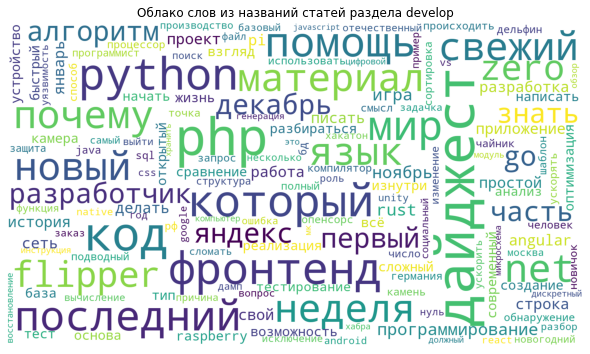

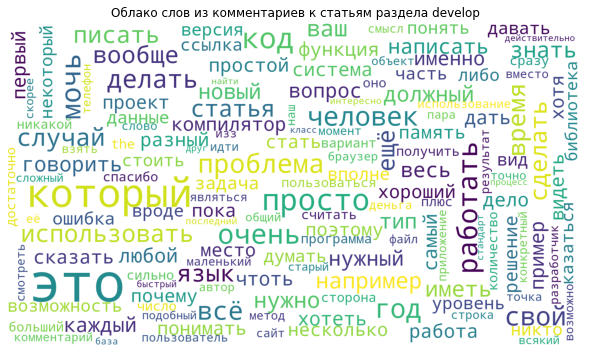

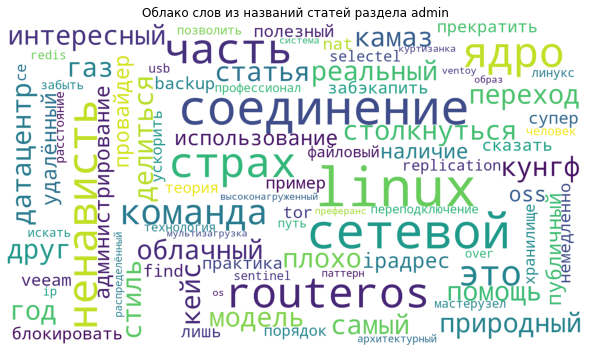

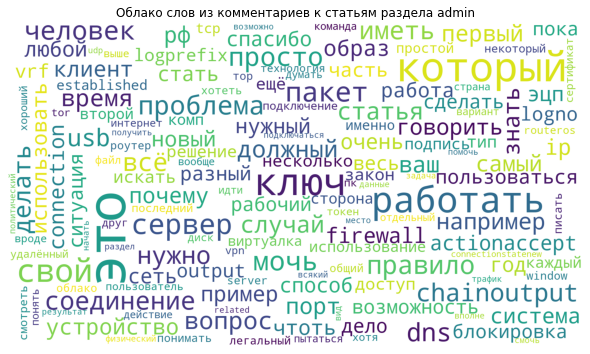

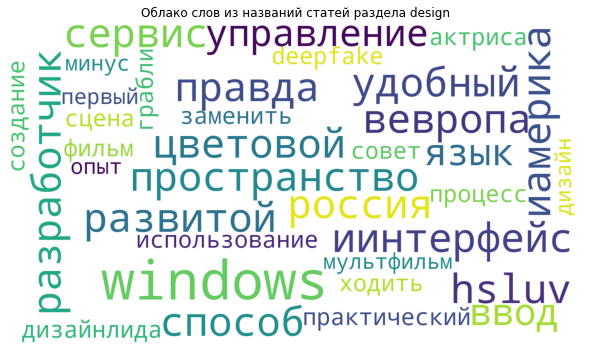

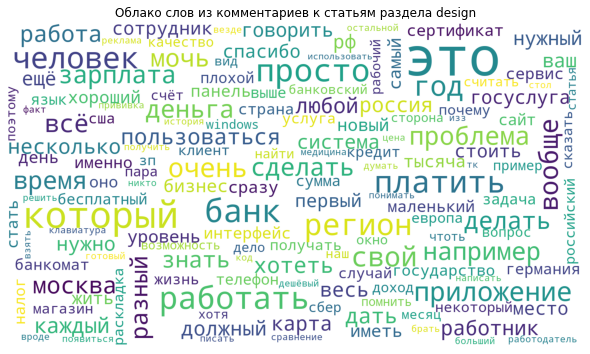

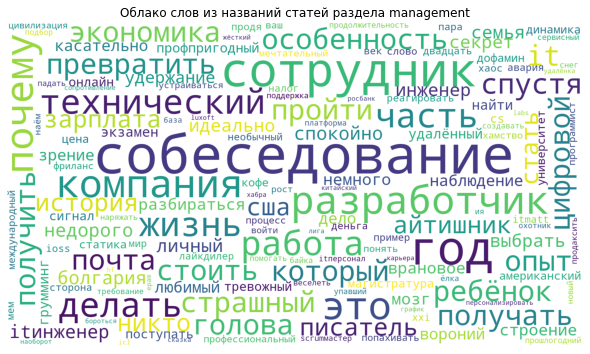

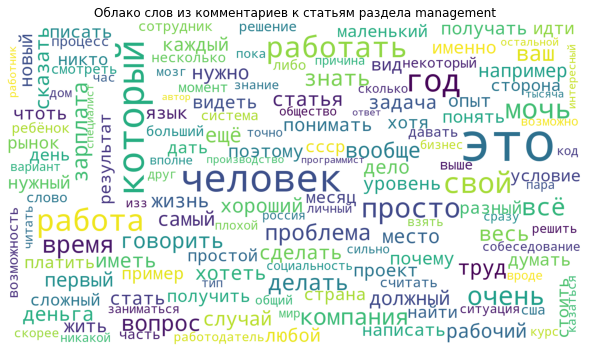

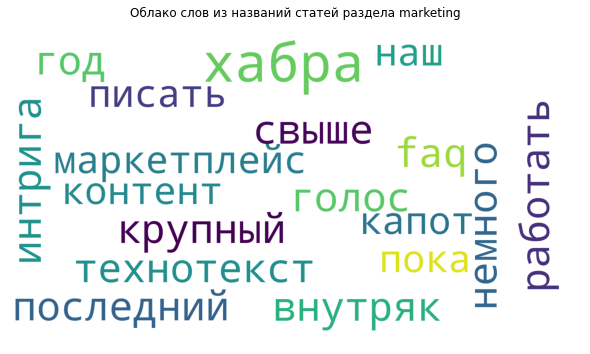

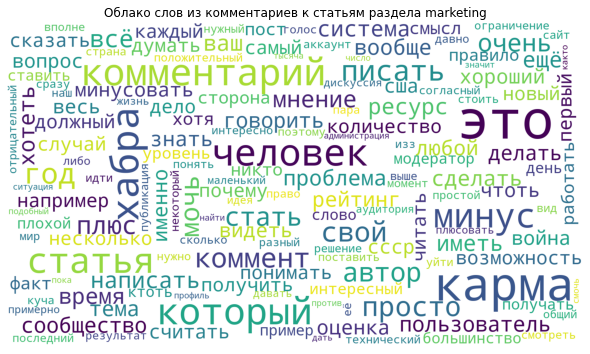

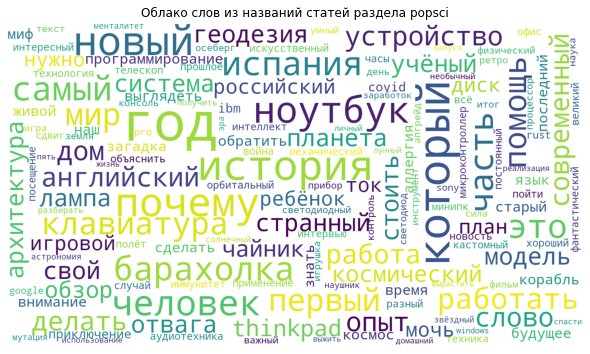

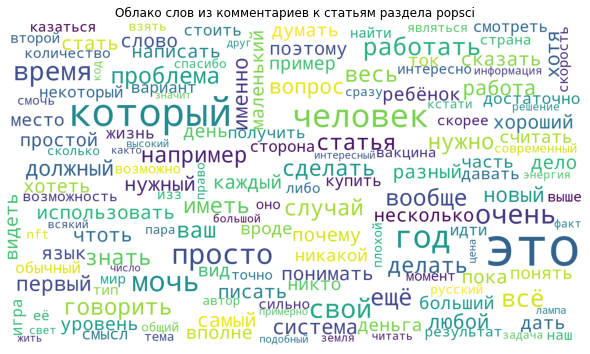

In [ ]:
for section in ['develop', 'admin', 'design', 'management', 'marketing', 'popsci']:
  titles_text = ' '.join(df[df['sections'] == section].titles.values)
  titles_text = Analytics.preprocess_text(titles_text)
  titles_text = Analytics.lemmatization(titles_text)
  Analytics.plot_wordcloud(titles_text, f'Облако слов из названий статей раздела {section}')

  comments_text = ' '.join(df[df['sections'] == section].dropna().comments.values)
  comments_text = Analytics.preprocess_text(comments_text)
  comments_text = Analytics.lemmatization(comments_text)
  Analytics.plot_wordcloud(comments_text, f'Облако слов из комментариев к статьям раздела {section}')

# Рейтинг вовлеченности

In [ ]:
df = df.dropna()
er_table = Analytics.calc_engagement_rate(df)
er_table = er_table.sort_values(by='ER', ascending=False)

In [ ]:
er_table[['titles', 'ER']].head()

,titles,ER
94,"11½ практических советов дизайн-лиду, или «Не ...",7.208333
120,Безопасность постковидной эпохи: мнения участн...,6.818182
702,"Как разработать микросхему, от идеи до результ...",6.464286
449,"Заднее число против обратной силы, или Миграци...",6.307692
83,Бесплатные ресурсы для инди-разработчиков,5.489362


In [ ]:
er_table[['titles', 'ER']].tail()

,titles,ER
300,Самый древний и один из самых красивых корабле...,0.406410
481,"Паразит, дарующий своим хозяевам «вечную моло...",0.366879
162,"Танк, которого нет в World of Tanks",0.302273
355,Задачи с Международной математической олимпиад...,0.282192
200,Как самостоятельно нарисовать себе ковидный ку...,0.202582


Графики распределения

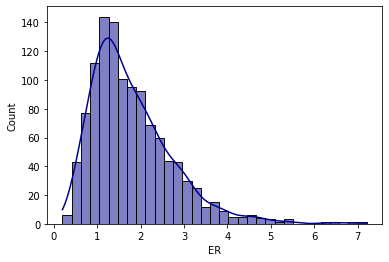

In [ ]:
plot = sns.histplot(er_table['ER'], kde=True, color = 'darkblue')

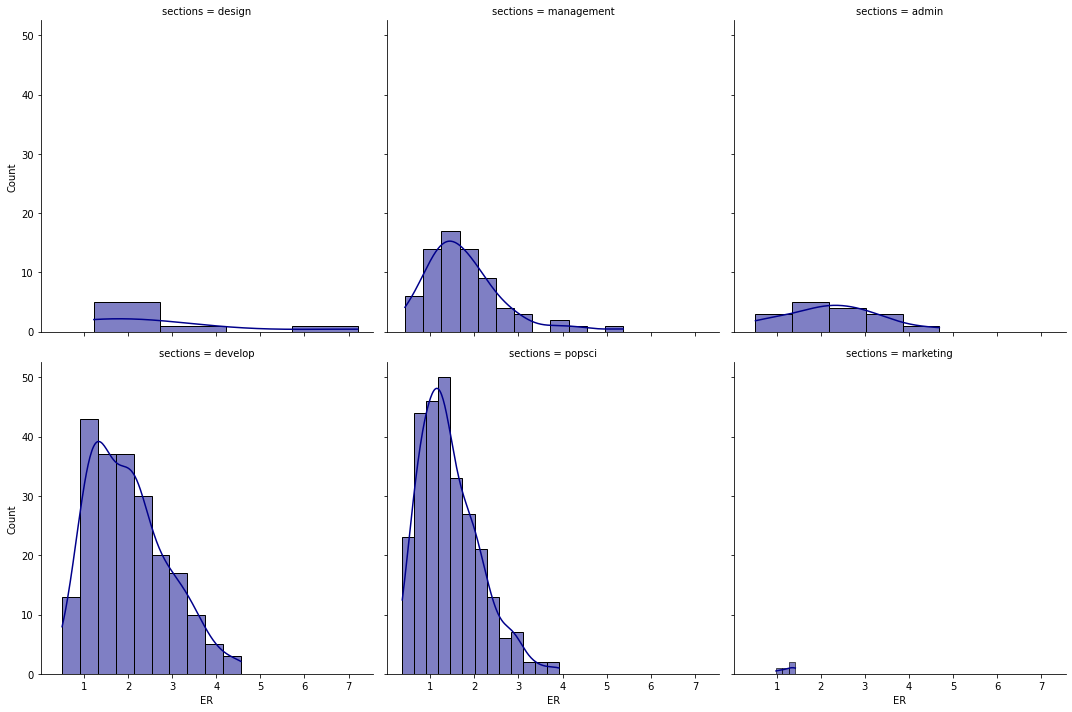

In [ ]:
single_title = er_table[er_table['sections'].isin(['develop', 'marketing', 'popsci', 'admin', 'design', 'management'])]

g = sns.FacetGrid(single_title[['ER', 'sections']], col="sections", col_wrap=3, height=5)
g.map(sns.histplot, 'ER', kde=True, color='darkblue')

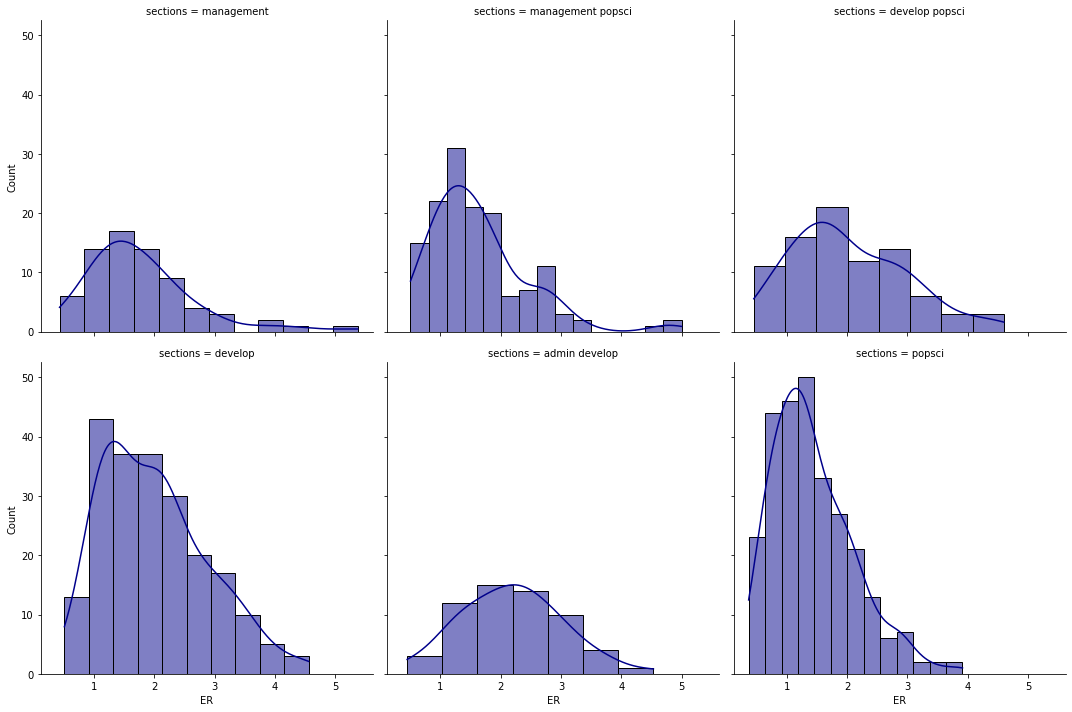

In [ ]:
s = df.groupby('sections')['titles'].count()
s = s[s > 50].index.tolist()
filter_er = er_table[er_table['sections'].isin(s)]

g = sns.FacetGrid(filter_er[['ER', 'sections']], col="sections", col_wrap=3, height=5)
g.map(sns.histplot, 'ER', kde=True, color='darkblue')

Box Plots показывают размах значений, 1 и 3 квартили, медиану, а также аномальные значение (выбросы, за пределами размаха). При сравнении develop и popsci можно заметить отличие в параметрах распределения: больший размах, большее среднее. 

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:670: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:670: UserWarning: Using the swarmplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


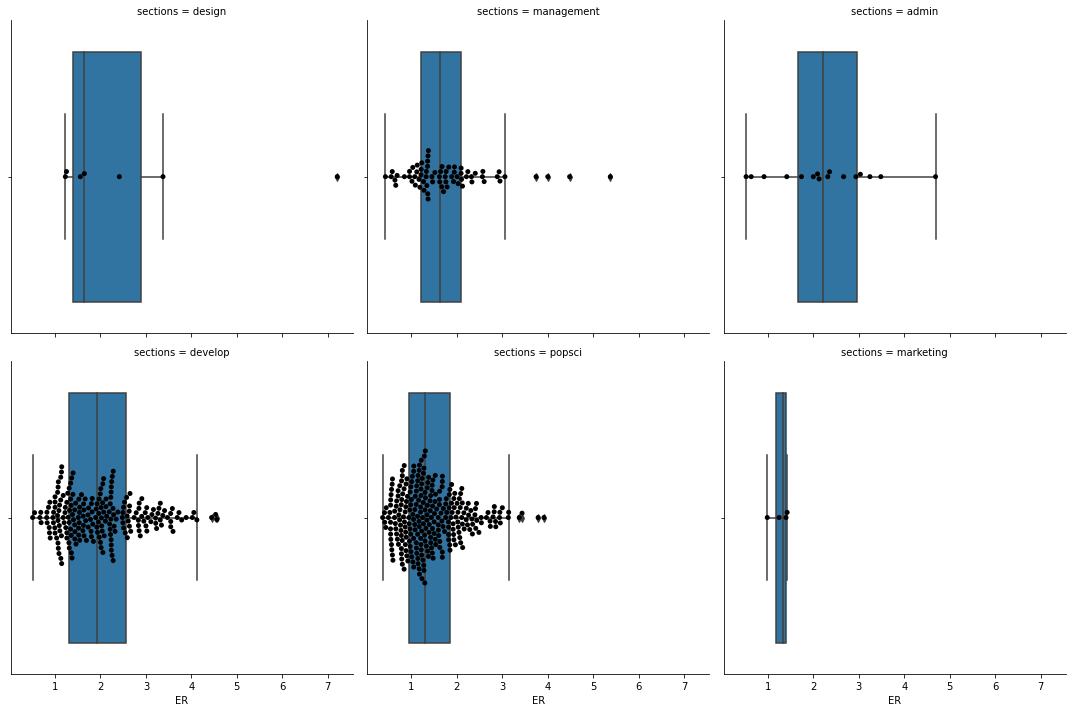

In [ ]:
g = sns.FacetGrid(single_title[['ER', 'sections']], col="sections", col_wrap=3, height=5)
g.map(sns.boxplot, 'ER')
g.map(sns.swarmplot, 'ER', color='black', dodge=True)

Boxplot'ы для самых популярных комбинаций потоков.

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:670: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:670: UserWarning: Using the swarmplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


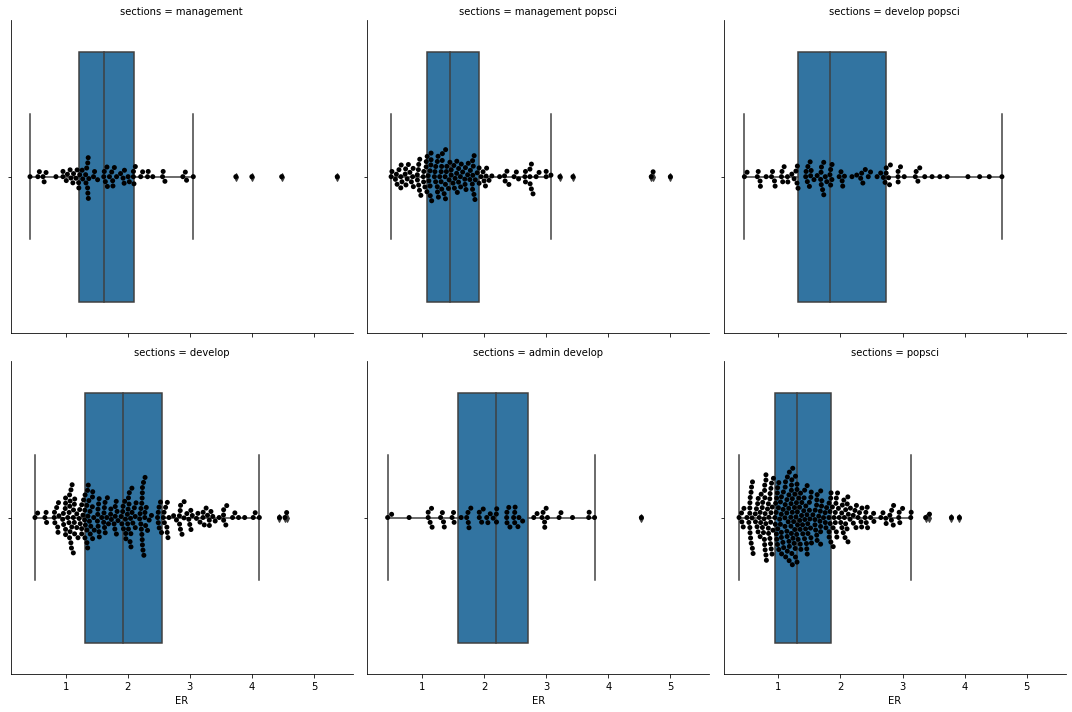

In [ ]:
g = sns.FacetGrid(filter_er[['ER', 'sections']], col="sections", col_wrap=3, height=5)
g.map(sns.boxplot, 'ER')
g.map(sns.swarmplot, 'ER', color='black', dodge=True)

Корреляционный анализ, для интерпретации результатов используется шкала Чеддока.

Корреляция между ER и section: слабая положительная корреляция для потока develop и слабая отрицательная корреляция для потока popsci.

In [ ]:
s_corr = er_table.sections.str.get_dummies(sep=' ').corrwith(er_table.ER)
print(s_corr.sort_values(ascending=False))

develop       0.212234
marketing     0.104708
design        0.096666
admin         0.038734
management   -0.061760
popsci       -0.202195
dtype: float64


Корреляция между ER и количеством разделов, в которых опубликована статья, не обнаружена.

In [ ]:
er_table['sections number'] = [len(section.split()) for section in er_table.sections.values]
er_table['sections number'] = er_table['sections number'].astype(str)
er_table['sections number'].str.get_dummies().corrwith(er_table['ER'])

1   -0.076942
2    0.087075
3    0.004860
4   -0.062770
dtype: float64

Распределение количества потоков, в которых опубликованы статьи (показательное распределение).

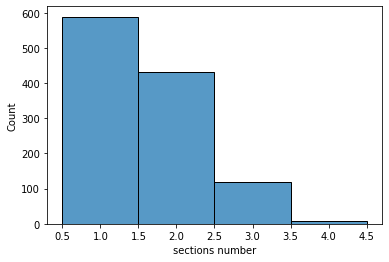

In [ ]:
er_table['sections number'] = er_table['sections number'].astype(int)
p = sns.histplot(data=er_table, x='sections number', discrete=True)

Распределение рейтинга вовлеченности по количеству потоков, в которых опубликованы статьи. Рейтинг вовлеченности при различных количествах потоках примерно одинаковый (отличие для 4 может быть связано с маленькой выборкой).

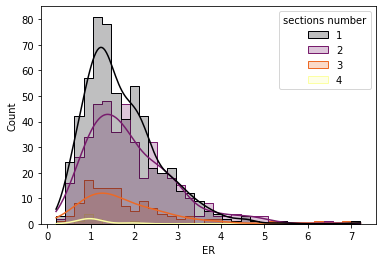

In [ ]:
h = sns.histplot(data=er_table, x='ER', hue='sections number', kde=True, element='step', palette='inferno')

Корреляция с популярными комбинациями потоков

In [ ]:
describe = er_table[['sections', 'ER']].groupby('sections').describe()['ER'].sort_values(by='mean', ascending=False)
describe = describe[describe['count'] > 10]
describe = describe.reset_index()
describe

,sections,count,mean,std,min,25%,50%,75%,max
0,admin,16.0,2.261749,1.101034,0.521569,1.659167,2.223230,2.961949,4.689655
1,admin develop,59.0,2.187222,0.841196,0.447436,1.573824,2.197368,2.710526,4.533333
2,popsci develop,24.0,2.181503,1.072017,0.800000,1.268434,1.932399,2.986067,4.393939
3,develop popsci,86.0,2.032491,0.949417,0.452941,1.308526,1.836088,2.731571,4.600000
4,develop,215.0,2.007586,0.873358,0.507143,1.310882,1.926316,2.560227,4.560000
5,management develop,43.0,1.944633,1.219583,0.505000,1.243654,1.604167,2.146042,6.464286
6,admin management develop,11.0,1.837413,1.508869,0.909524,1.261711,1.414286,1.530468,6.307692
7,management,71.0,1.767499,0.897900,0.427419,1.211655,1.623529,2.097236,5.375000
8,design popsci,16.0,1.710746,0.886619,0.202582,1.086343,1.946230,2.329651,2.873684
9,management popsci,141.0,1.630015,0.808451,0.503061,1.084211,1.450000,1.920000,5.000000


In [ ]:
top_sections_df = df[df.sections.isin(describe.sections)]

Слабая положительная корреляция для потоков develop и admin develop, слабая отрицательная корреляция для потока popsci. 

In [ ]:
top_sections_df.sections.str.get_dummies().corrwith(top_sections_df['ER']).sort_values(ascending=False)

develop                      0.141091
admin develop                0.117321
develop popsci               0.091429
popsci develop               0.072548
admin                        0.070276
management develop           0.042750
admin management develop     0.008828
management                   0.001846
design popsci               -0.007119
admin develop popsci        -0.026160
management develop popsci   -0.035582
admin popsci                -0.037990
management popsci           -0.058454
admin management popsci     -0.063883
popsci                      -0.216262
dtype: float64

# Вывод: 
На вовлеченность пользователей наибольшое влияние оказывает поток, в котором была опубликована статья. Потоки отличаются друг от друга тематикой, спецификой, аудиторией. Например, научно популярные статьи в среднем имеют много просмотров, однако у них низкая активность ввиду особенностей жанра, а статьи из раздела разработки (обучающие статьи, обзор новых технологий) имеют более высокую активность: их чаще добавляют в закладки, чтобы всегда можно было найти полезную информацию. 

Таким образом, статьи из некоторых потоков получают больше активности ввиду "особенностей жанра", большей применимости в реальной жизни и прочих подобных факторов.